# Word2Vec

This notebook explores the traditional approach to text classification using word-embeddings and a convolutional neural network as classifier.

It was only used during an initial exploration phase.

## Load data

In [3]:
import pandas as pd
import numpy as np

In [5]:
acars = pd.read_csv('../data/non-en-data.csv', index_col=0)

In [6]:
acars.head()

,Txt
0,CHECK\nWILL DO\nTHANKS FOR THE HEADS UP\nSHANE...
1,QUORYOAAF~1TNI01102006\nWEATHER REPORT\n METAR...
2,QUDPCULUA-1GATE ASSIGN\nUA148 GRUEWR\nGATE C12...
3,.BJSAGCA 140309\nAGM\nAN B-6076/MA 951A/TP SAT...
4,QUORYOAAFT9POS040


# Extract corpus (list of words) from messages

In [9]:
import re
from collections import Counter
from itertools import chain

delimiter = '\n| '
def split_msg(msg):
    words = re.split(delimiter, str(msg))
    return [w for w in words if w != '']

def get_words(df, min_freq=5):
    words = df['Txt'].apply(lambda x: split_msg(x))
    words = list(chain(*list(words.values)))
    
    word_counts = Counter(words)
    words = [word for word in words if word_counts[word] >= min_freq]
    
    return words

words = get_words(acars)

# Create word to token mapping 

In [11]:
def get_vocab(words):
    word_counts = Counter(words)
    vocab_sorted = sorted(word_counts, key=word_counts.__getitem__, reverse=True)
    word_to_token = {w: i for i, w in enumerate(vocab_sorted)}
    token_to_word = {i:w for w,i in word_to_token.items()}
    
    return word_to_token, token_to_word

word_to_token, token_to_word = get_vocab(words)

words_tokenized = [word_to_token[w] for w in words]
print(f'Number of words in the corpus: {len(words_tokenized)}')
print(f'Number of words in the vocab: {len(word_to_token)}')

Number of words in the corpus: 192256
Number of words in the vocab: 6866


# Create targets for training SkipGram

In [183]:
def get_context(words, idx, window_size=4):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return target_words

# Create training batches

In [199]:
def batch_iter(words, batch_size, window_size=4):
    """ Create a generator of word batches as a tuple (inputs, targets) """ 
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_context(batch, ii, window_size)
        
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        
        yield x, y

# Define Embedding model

In [187]:
import torch
from torch import nn
import torch.optim as optim

In [203]:
class SkipGram(nn.Module):
    """A simple SkipGram model to learn word embeddings"""
    
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(n_vocab, n_embed)
        self.output_layer = nn.Linear(n_embed, n_vocab)
        self.non_linear = nn.LogSoftmax(1)
        
    def forward(self, x):
        z = self.embedding_layer(x)
        scores = self.output_layer(z)
        pred = self.non_linear(scores)
        
        return pred

# Training Word Embedding model

In [209]:
def train(words_tokenized, model_embed, lossfunc, optimizer, num_epoch=5, batch_size=500):
    
    num_batches = len(words_tokenized) // batch_size
    
    for epoch in range(num_epoch):
        batch_num = 0
        for inputs, labels in batch_iter(words_tokenized, batch_size):
            # Create torch variables corresponding to features and labels
            inputs, labels = torch.LongTensor(inputs), torch.LongTensor(labels)

            # Compute model predictions and loss
            labels_pred = model_embed(inputs)
            loss = lossfunc(labels_pred, labels)

            # TODO: Step 3 - do a backward pass and a gradient update step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_num % 100 == 0:
                print ('Epoch [%d/%d], Batch[%d/%d], Loss: %.4f' %(epoch+1, num_epoch, batch_num+1, num_batches, loss.item()))
                
            batch_num += 1

In [210]:
embedding_dim = 300
learning_rate = 0.003

model = SkipGram(len(word_to_token), embedding_dim)
lossfunc = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(words_tokenized, model, lossfunc=lossfunc, optimizer=optimizer, num_epoch=5)

Epoch [1/5], Batch[1/384], Loss: 9.0061
Epoch [1/5], Batch[101/384], Loss: 6.8402
Epoch [1/5], Batch[201/384], Loss: 7.1087
Epoch [1/5], Batch[301/384], Loss: 7.4591
Epoch [2/5], Batch[1/384], Loss: 6.2600
Epoch [2/5], Batch[101/384], Loss: 5.1250
Epoch [2/5], Batch[201/384], Loss: 6.2769
Epoch [2/5], Batch[301/384], Loss: 6.5974
Epoch [3/5], Batch[1/384], Loss: 5.9506
Epoch [3/5], Batch[101/384], Loss: 4.7531
Epoch [3/5], Batch[201/384], Loss: 5.9672
Epoch [3/5], Batch[301/384], Loss: 6.2533
Epoch [4/5], Batch[1/384], Loss: 5.8227
Epoch [4/5], Batch[101/384], Loss: 4.7156
Epoch [4/5], Batch[201/384], Loss: 5.7898
Epoch [4/5], Batch[301/384], Loss: 6.0994
Epoch [5/5], Batch[1/384], Loss: 5.6326
Epoch [5/5], Batch[101/384], Loss: 4.5983
Epoch [5/5], Batch[201/384], Loss: 5.7590
Epoch [5/5], Batch[301/384], Loss: 5.9207


# Visualize learned embeddings

In [211]:
# Getting embeddings from the embedding layer of our model, by name
embeddings = model.embedding_layer.weight.data.numpy()

In [223]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

plt.rcParams.update({'axes.spines.right': True,
                     'axes.spines.top': True,
                     'axes.edgecolor': 'k',
                     'axes.labelsize':20,
                     'axes.titlesize':22,
                     'xtick.labelsize': 18,
                     'xtick.color': 'k',
                     'ytick.labelsize': 18,
                     'ytick.color': 'k',
                     'grid.color':'0.7',
                     'font.family': 'serif',
                     'font.sans-serif': 'cm',
                     'text.usetex': False,
                     'figure.titlesize': 22})

sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('colorblind'))

COLOURS = list(sns.color_palette('colorblind'))

In [218]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

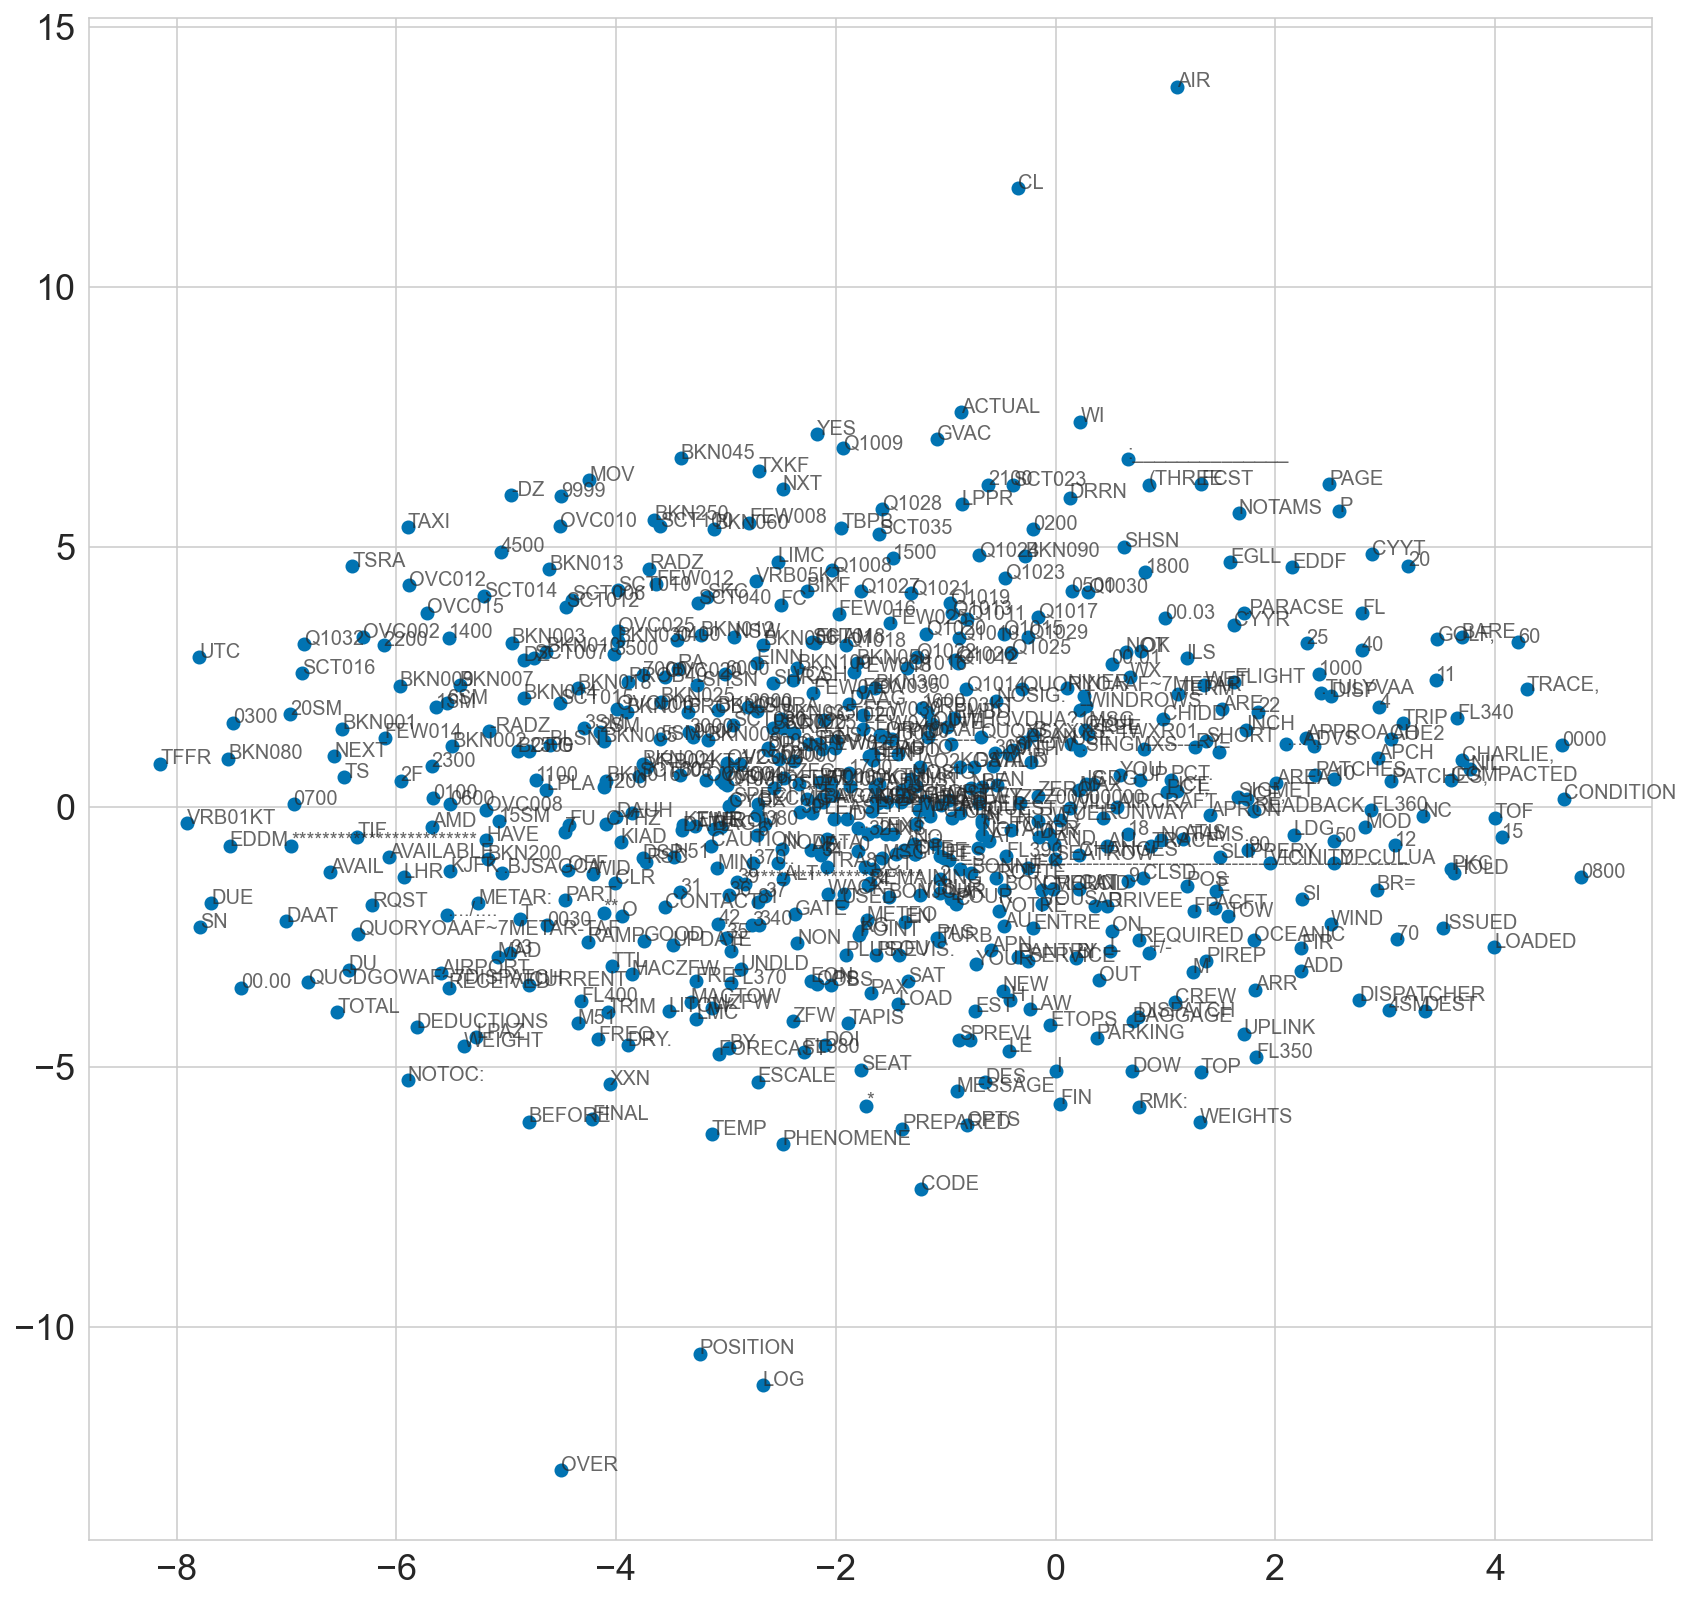

In [224]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color=COLOURS[0])
    plt.annotate(token_to_word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

# Toy classification task: Label as sensor or plaintext

In [12]:
plaintxt = ['AIRPORT', 'IS', 'THANKS', 'DO', 'WILL']

def get_label(msg):
    words = split_msg(msg)
    if np.any([p in words for p in plaintxt]):
        return 1
    else:
        return 0

acars['Label'] = acars['Txt'].apply(lambda x: get_label(x))

In [13]:
messages = list(acars['Txt'].apply(lambda msg: split_msg(msg)).values)
labels = acars['Label'].values

# Encode messages with learned embeddings

In [14]:
def tokenize_messages(messages, word_to_token):
    messages_tokens = []
    for msg in messages:
        msg_tokens = []
        for word in msg:
            try:
                msg_tokens.append(word_to_token[word]+1)
            except:
                msg_tokens.append(0)
        messages_tokens.append(msg_tokens)
    return messages_tokens

messages_tokens = tokenize_messages(messages, word_to_token)

# Padding 

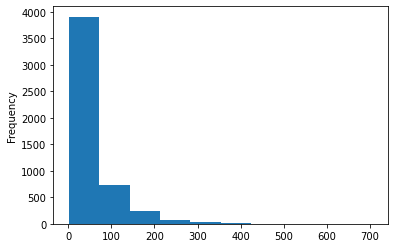

In [17]:
acars['Length'] = acars['Txt'].apply(lambda x: len(split_msg(x)))
seq_length = int(acars['Length'].quantile(.9))

ax = acars['Length'].plot.hist()

In [18]:
def pad_messages(messages_tokens, seq_length):
    ''' Return features of tokenized_reviews, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    features = np.zeros((len(messages_tokens), seq_length), dtype=int)

    for i, row in enumerate(messages_tokens):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

features = pad_messages(messages_tokens, seq_length)

# Create data loader

In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(features), torch.from_numpy(labels))

# dataloaders
batch_size = 10

# shuffling and batching data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [24]:
train_loader.dataset.tensors[0].shape

torch.Size([5000, 122])

# Define CNN for classification

In [429]:
import torch.nn.functional as F

class AcarsCNN(nn.Module):
    """
    Simple test CNN to distinguish two classes
    """

    def __init__(self, embedding_weights, output_size,
                 num_filters=100, kernel_sizes=[3, 4, 5], freeze_embeddings=True, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(AcarsCNN, self).__init__()

        # set class vars
        self.num_filters = num_filters
        self.vocab_size = embedding_weights.shape[0]
        self.embedding_dim = embedding_weights.shape[1]
        
        # Embedding layer
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        # Set weights to pre-trained
        self.embedding.weight = nn.Parameter(torch.from_numpy(embedding_weights))
        # (optional) freeze embedding weights
        if freeze_embeddings:
            self.embedding.requires_grad = False
        
        # Convolutional layers
        self.convs_1d = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embedding_dim), padding=(k-2,0)) for k in kernel_sizes])
        
        # Fully-connected output layer for classification
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, output_size) 
        
        # Drop-out and sigmoid layers
        self.dropout = nn.Dropout(drop_prob)
        self.sig = nn.Sigmoid()
        
    
    def conv_and_pool(self, x, conv):
        """
        Convolutional + max pooling layer
        """
        # squeeze last dim to get size: (batch_size, num_filters, conv_seq_length)
        # conv_seq_length will be ~ 200
        x = F.relu(conv(x)).squeeze(3)
        
        # 1D pool over conv_seq_length
        # squeeze to get size: (batch_size, num_filters)
        x_max = F.max_pool1d(x, x.size(2)).squeeze(2)
        
        return x_max

    def forward(self, x):
        """
        Defines how a batch of inputs, x, passes through the model layers.
        Returns a single, sigmoid-activated class score as output.
        """
        # embedded vectors
        embeds = self.embedding(x) # (batch_size, seq_length, embedding_dim)
        # embeds.unsqueeze(1) creates a channel dimension that conv layers expect
        embeds = embeds.unsqueeze(1)
        
        # get output of each conv-pool layer
        conv_results = [self.conv_and_pool(embeds, conv) for conv in self.convs_1d]
        
        # concatenate results and add dropout
        x = torch.cat(conv_results, 1)
        x = self.dropout(x)
        
        # final logit
        logit = self.fc(x) 
        
        # sigmoid-activated --> a class score
        return self.sig(logit)

In [430]:
output_size = 1 # binary class (1 or 0)
num_filters = 100
kernel_sizes = [3, 4, 5]

embeddings_pad = np.vstack([np.zeros(embeddings.shape[1]), embeddings])

cnn = AcarsCNN(embeddings_pad, output_size, 
                   num_filters=num_filters, kernel_sizes=kernel_sizes)

print(cnn)

AcarsCNN(
  (embedding): Embedding(6867, 300)
  (convs_1d): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1), padding=(1, 0))
    (1): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1), padding=(2, 0))
    (2): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1), padding=(3, 0))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sig): Sigmoid()
)


# Train CNN 

In [431]:
def train(train_loader, cnn, lossfunc, optimizer, num_epoch=5, print_every=100):
    
    num_samples_train = train_loader.dataset.tensors[0].shape[0]
    num_batches = num_samples_train // train_loader.batch_size
    
    cnn.train()
    cnn.float()
    
    for epoch in range(num_epoch):
        batch_num = 1
        for inputs, labels in train_loader:
            net.zero_grad()
            
            # Compute model predictions and loss
            labels_pred = cnn(inputs)
            loss = lossfunc(labels_pred.squeeze(), labels.float())

            # Do a backward pass and a gradient update step
            loss.backward()
            optimizer.step()

            if batch_num % print_every == 0:
                print ('Epoch [%d/%d], Batch[%d/%d], Loss: %.4f' %(epoch+1, num_epoch, batch_num, num_batches, loss.item()))
                
            batch_num += 1

In [432]:
lr = 0.001

lossfunc = nn.BCELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)

train(train_loader, cnn, lossfunc, optimizer, 
      num_epoch=2, print_every=100)

Epoch [1/2], Batch[100/500], Loss: 0.0000
Epoch [1/2], Batch[200/500], Loss: 10.0000
Epoch [1/2], Batch[300/500], Loss: 10.0000
Epoch [1/2], Batch[400/500], Loss: 0.0000
Epoch [1/2], Batch[500/500], Loss: 0.0000
Epoch [2/2], Batch[100/500], Loss: 0.0000
Epoch [2/2], Batch[200/500], Loss: 10.0000
Epoch [2/2], Batch[300/500], Loss: 0.0000
Epoch [2/2], Batch[400/500], Loss: 0.0000
Epoch [2/2], Batch[500/500], Loss: 10.0000


In [444]:
cnn.eval()

m = np.random.randint(0, len(acars))
# convert to tensor to pass into your model
test_input = torch.from_numpy(np.expand_dims(features[m], axis=0))
batch_size = test_input.size(0)

output = cnn(test_input)

# convert output probabilities to predicted class (0 or 1)
pred = torch.round(output.squeeze()) 

# printing output value, before rounding
# print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))

# Print Message
print(f"Message:\n\n{acars['Txt'][m]}")
# Which class
if(pred.item()==1):
    print("was classified as written by: Human!")
else:
    print("was classified as written by: Machine!")

Message:

.ORYOO8X 191345 
AGM
AN F-GOTO/MA 230I
-  UPLINK* ETOPS GO MESSAGE * BJR *
CHECK NOTAMS :
LPLA / TXKF / TFFR  / TAPA: RAS
CHECK METEO
SIGMET : RAS
TAF LPLA 191101Z 1912/2012 24008KT 9999 FEW025= 
LPLA 191300Z 24008KT 9999 FEW025 18/11 Q1021= 
**
TAF TXKF 191131Z 1912/2012 31020KT 9999 -SHRA FEW020 SCT060 BKN200
 TEMPO 1912/1919 31020G30KT 4800 SHRA BKN012 OVC030 PROB30 TEMPO
 1912/1919 32025G35KT 
SPECI TXKF 191330Z 35019KT 9000 -SHRA SCT015 SCT033 BKN060 BKN170
 16/13 Q1004 
**
TAF TFFR 191100Z 1912/2012 07010KT 9999 SCT030 PROB30 TEMPO 1912/1918
 SHRA SCT018TCU BECMG 1923/2003 VRB02KT= 
TFFR 191330Z AUTO 09006KT 040V140 9999 FEW026 27/20 Q1016 TEMPO SHRA
 SCT018TCU= 
**
TAF TAPA 191100Z 1912/2012 07006KT 9999 SCT022= 
TAPA 191300Z 07009KT 9999 FEW019 25/20 Q1016 NOSIG= 
**
REACTUALISATION FENETRES METEO:
LPLA SUITABLE FROM 1612 UTC / TO 2305 UTC
TXKF SUITABLE FROM 2107 UTC / TO 2328 UTC
TFFR SUITABLE FROM 2125 UTC / TO 2332 UTC
BON VOL/ DAVID / OPS ACA
was classified as wri